## Movie Recommendation System

In [9]:
# import library we need
import matplotlib.pyplot as plt
import pandas as pd
import pyspark as spark
# spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import cross_validate
from wordcloud import WordCloud

In [10]:
## active SparkSession
spark = SparkSession\
        .builder\
        .appName('ALSExample').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [11]:
## import csv file
reviews = pd.read_csv('../../data/raw/ratings.csv')
links = pd.read_csv('../../data/raw/links.csv')
movies = pd.read_csv('../../data/raw/movies.csv')
tags = pd.read_csv('../../data/raw/tags.csv')

movie_ratings = spark.read.csv('../../data/raw/ratings.csv', header='true', inferSchema='true')
movie_titles = spark.read.csv('../../data/raw/movies.csv', header='true', inferSchema='true')
movie_ratings = movie_ratings.drop('timestamp')

## Explore data

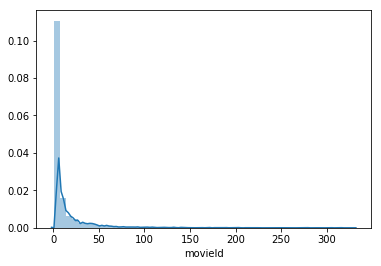

In [12]:
sns.distplot(reviews.movieId.value_counts());

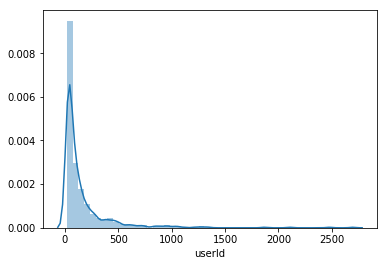

In [13]:
sns.distplot(reviews.userId.value_counts());

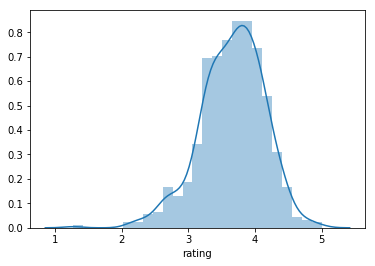

In [14]:
sns.distplot(reviews.groupby('userId')['rating'].mean());

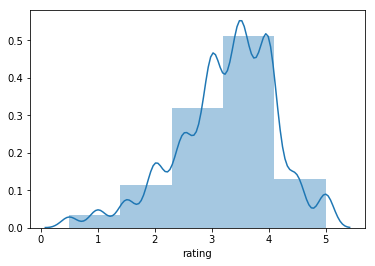

In [15]:
sns.distplot(reviews.groupby('movieId')['rating'].mean(),bins=5);

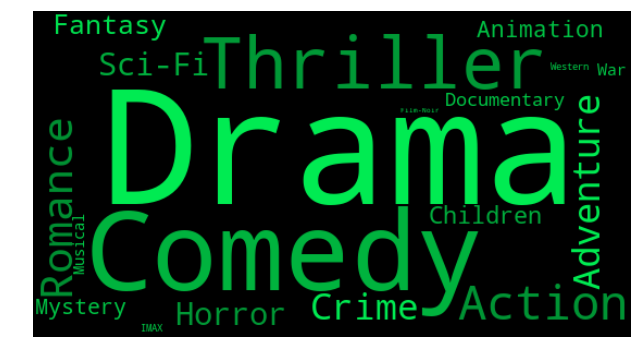

In [16]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

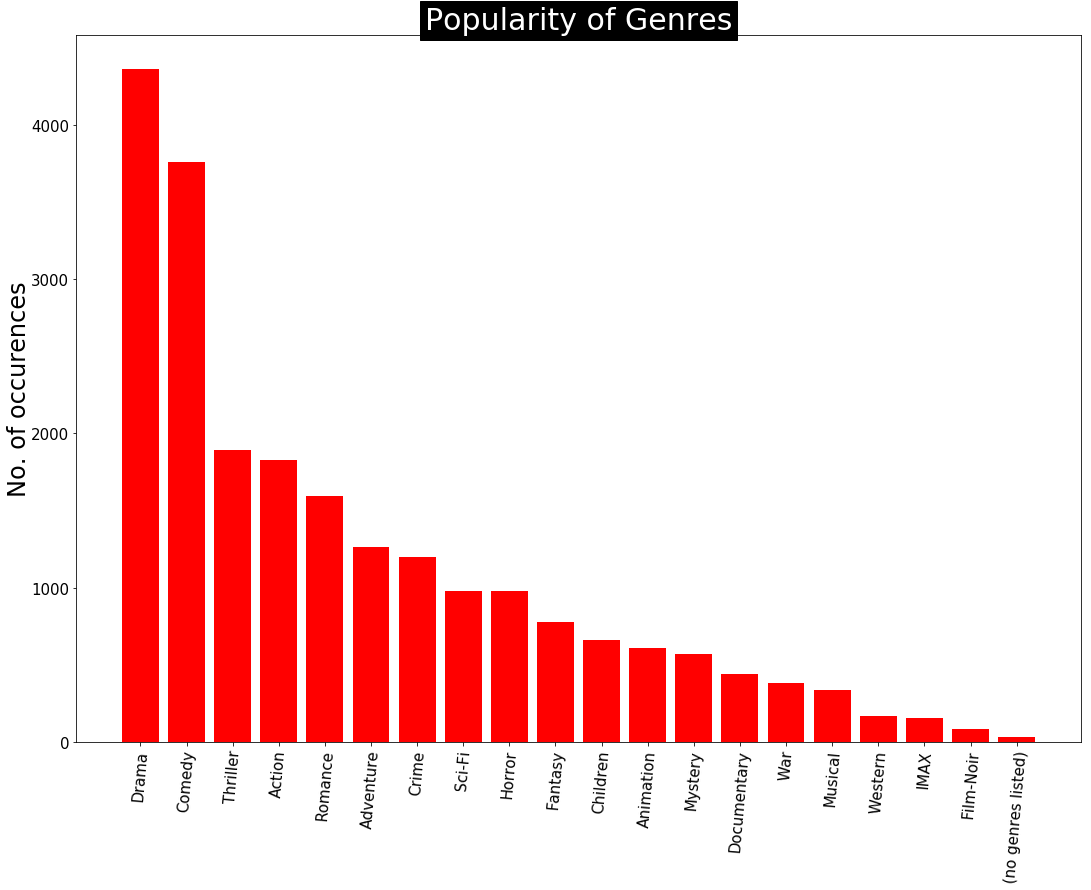

In [17]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(1,1,1)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show();
# fig.savefig('../../src/visualization/genre_occurences.png')

## Data cleaning 

In [18]:
# data cleaning add year column in movies from title
movies['year'] = movies['title'].apply(lambda x: x[-5:-1].strip('('))
movies['year'] = movies['year'].apply(lambda x: x.strip(')'))
movies['year'] = movies['year'].apply(lambda x: x.strip('-'))
movies = movies.drop(movies[movies['title'].str.contains("\(") == False].index)
# split genres to list
movies['genres'] = movies.genres.str.split("|")

# combine tags each movie 
tags['joined_tags'] = tags.groupby('movieId')['tag'].transform(lambda x: ' '.join(x))
tags = tags[['movieId', 'joined_tags']].drop_duplicates()

# joint movies and tags by movieId
movies_w_tags = movies.merge(tags, on='movieId')
movies_w_tags['genres'] = movies_w_tags['genres'].apply(lambda x: ' '.join([str(elem) for elem in x]) )
movies_w_tags['joined_tags'] = movies_w_tags['joined_tags'].apply(lambda x: x.replace(',', ''))
movies_w_tags['keywords'] = movies_w_tags['genres'] +' '+ movies_w_tags['joined_tags']
movies_w_tags = movies_w_tags.drop(['genres',"joined_tags"], axis=1)

movies_w_tags

,movieId,title,year,keywords
0,1,Toy Story (1995),1995,Adventure Animation Children Comedy Fantasy pi...
1,2,Jumanji (1995),1995,Adventure Children Fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),1995,Comedy Romance moldy old
3,5,Father of the Bride Part II (1995),1995,Comedy pregnancy remake
4,7,Sabrina (1995),1995,Comedy Romance remake
...,...,...,...,...
1566,183611,Game Night (2018),2018,Action Comedy Crime Horror Comedy funny Rachel...
1567,184471,Tomb Raider (2018),2018,Action Adventure Fantasy adventure Alicia Vika...
1568,187593,Deadpool 2 (2018),2018,Action Comedy Sci-Fi Josh Brolin Ryan Reynolds...
1569,187595,Solo: A Star Wars Story (2018),2018,Action Adventure Children Sci-Fi Emilia Clarke...


# Spark ALS Model

In [19]:
# split into training and testing sets
(training, test) = movie_ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5,rank=4, regParam=0.01, userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop')

# fit the ALS model to the training set
model = als.fit(training)

In [20]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating',
                                predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('Root-mean-square error = ' + str(rmse))

Root-mean-square error = 0.9782696910128438


In [350]:
# initialize the ALS model
als_model = ALS(userCol='userId', itemCol='movieId', 
                ratingCol='rating', coldStartStrategy='drop')

# create the parameter grid                 
params = ParamGridBuilder()\
          .addGrid(als_model.regParam, [0.01, 0.001, 0.1])\
          .addGrid(als_model.rank, [4, 10, 50]).build()

# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als_model, estimatorParamMaps=params,evaluator=evaluator,parallelism=4)
best_model = cv.fit(movie_ratings)    

# We see the best model has a rank of 50, so we will use that in our future models with this dataset
best_model.bestModel.rank

4

In [22]:
def new_user_recs(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    movie_id_list = []
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5, rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id, movie_title_df)
        movie_id_list.append(movie_id)
        print(movie_id)
        print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1, movie_string, rating))
        
    return movie_id_list

def name_retriever(movie_id, movie_title_df):
    return movie_title_df.where(movie_title_df.movieId == movie_id).take(1)[0]['title']

In [23]:
# try out functions with the movies listed above
user_id = 1000
user_ratings_1 = [(user_id,3257,5),
                  (user_id,2459,1),
                  (user_id,2513,2),
                  (user_id,6502,2),
                  (user_id,1091,2),
                  (user_id,441,4)]
new_user_recs(user_id,
             new_ratings=user_ratings_1,
             rating_df=movie_ratings,
             movie_title_df = movie_titles ,
             num_recs = 5)

3257
Recommendation 1: Bodyguard, The (1992)  | predicted score :4.98429012298584
441
Recommendation 2: Dazed and Confused (1993)  | predicted score :3.994199275970459
6942
Recommendation 3: Love Actually (2003)  | predicted score :3.8960723876953125
68954
Recommendation 4: Up (2009)  | predicted score :3.6533355712890625
830
Recommendation 5: First Wives Club, The (1996)  | predicted score :3.6530539989471436


[3257, 441, 6942, 68954, 830]

 ## CountvVectorizer

In [27]:
cos_sim = count_vec(movies_w_tags)
indices = pd.Series(movies_w_tags.index)
recommendations(0, count_vec(movies_w_tags))

[544, 666, 1033, 812, 643, 160, 1444, 1281, 1274, 248]

In [28]:
def count_vec(df):
    count_vect = CountVectorizer(stop_words='english')
    counts = count_vect.fit_transform(df.keywords)
    cos_sim = cosine_similarity(counts, counts)
    
    return cos_sim

def recommendations(title, cos_sim = cos_sim):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return recommended_movies

## TFIDF

In [29]:
vectorizer = TfidfVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(movies_w_tags.keywords)
tfidf_cos = cosine_similarity(X, X)
recommendations(1, tfidf_cos)

[1567, 1366, 939, 1210, 1349, 875, 617, 1281, 1444, 866]

## Final movie reInput and output interface

In [36]:
def user_exist(uid, reviews):
    """
    check if user exist already
    iuput: user id and dataFrame
    output: boolean
            True if user is exist
            False if it is a new user
    """

    if uid in reviews.userId.unique():
        return True
    else:
        return False
    
def get_ratings(uid, reviews):
    """
    get user's ratings for each movie
    iuput: user id and reviews dataFrame
    output: a list of tuple
            (userId, movieId, rating)
    """
    user_ratings=[]
    temp = reviews[reviews['userId']==uid].loc[:,['movieId', 'rating']]
    for index, row in temp.iterrows():
        user_ratings.append((uid, int(row['movieId']), float(row['rating'])))
    return user_ratings

def name_retriever_index(movie_id, titles):
    return list(titles[titles.index==movie_id]['title'])[0]

def get_titles_index(movie_ids, movie_titles):
    titles = []
    for mid in movie_ids:
        print(name_retriever_index(mid, movie_titles))
        
def get_titles_mid(movie_ids, movies):
    for mid in movie_ids:
        print(list(movies[movies['movieId']==mid]['title'])[0])
        
def get_one_titles_mid(movie_id, movies):
    print(list(movies[movies['movieId']==movie_id].title)[0])
        
def get_top_genre(person_recommend, genre):
    movie_list = []
    for i in person_recommend[0][1]:
        movie = i[0]
        info = name_retriever(movie,movie_titles)
        title = info[0]
        genres = info[1].split('|')
        for j in genres:
            for k in genre:
                if j == k:
                    movie_list.append((title, genres))
    return movie_list[:5]

def get_movie_choose_genre_index(movie_ids, genre_input, movies):
    movie_in_genre = []
    for mid in movie_ids:
        temp = movies[movies.index==mid]
        for genres_list in temp['genres']:
            for each_genres in genres_list:
                for genre in genre_input:
                    if genre == each_genres:
                        movie_in_genre.append(mid)   
                        break
    return movie_in_genre  


def get_movie_choose_genre_mid(movie_ids, genre_input, movies):
    movie_in_genre = []
    for mid in movie_ids:
        temp = movies[movies.movieId==mid]
        for genres_list in temp['genres']:
            for each_genres in genres_list:
                for genre in genre_input:
                    if genre == each_genres:
                        movie_in_genre.append(mid)   
                        break
    return movie_in_genre 

def content_after_collab(movie_id_index, movies, print_number=0):
    if print_number == 0:
        for mid in movies.index:
            get_titles_index(tfidf_recs(mid)[1], movies)
    else:
        for mid in movies.index:
            get_titles_index(tfidf_recs(mid)[1], movies)
            print_number -= 1
            if print_number==0:
                break
        
def get_index(movieId_list, movies):
    movieIndex_list = []
    for mid in movieId_list:
        movieIndex_list.append(movies[movies['movieId']==mid].index[0])
    return movieIndex_list

def topfivepop(ratings, return_number = 5):
    return reviews.groupby(['movieId']).count().sort_values('rating',ascending=False)[0:return_number].index

def topfiverating(ratings,return_number = 5, min_rating_num=10):
    movieId_min_ratting = reviews.groupby("movieId").filter(lambda x: len(x) > min_rating_num)
    return movieId_min_ratting.groupby("movieId").mean().sort_values('rating',ascending=False)[0:return_number].index

def new_user_recs_wo_print(user_id, new_ratings, rating_df, movie_title_df, num_recs):
    # turn the new_recommendations list into a spark DataFrame
    movie_id_list = []
    new_user_ratings = spark.createDataFrame(new_ratings,rating_df.columns)
    
    # combine the new ratings df with the rating_df
    movie_ratings_combined = rating_df.union(new_user_ratings)
    
    # create an ALS model and fit it
    als = ALS(maxIter=5, rank=50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
    model = als.fit(movie_ratings_combined)
    
    # make recommendations for all users using the recommendForAllUsers method
    recommendations = model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    recs_for_user = recommendations.where(recommendations.userId == user_id).take(1)
    
    for ranking, (movie_id, rating) in enumerate(recs_for_user[0]['recommendations']):
        movie_string = name_retriever(movie_id, movie_title_df)
        movie_id_list.append(movie_id)
#         print('Recommendation {}: {}  | predicted score :{}'.format(ranking+1, movie_string, rating))  
    return movie_id_list

def print_sep_line():
    print("\n"+"="*40)
    
def print_topfive(reviews, movies):
    print("Top 5 populer movies:")
    get_titles_mid(topfivepop(reviews, return_number=5), movies)
    print_sep_line()
    print("Top 5 rating movies:")
    get_titles_mid(topfiverating(reviews, return_number=5), movies)
    print_sep_line()
    
def new_ratings_input(user):
    num = int(input("How many movie ratings do you want to input:"))
    ratings = []
    if num==0:
        return False
    else:
        for i in range(num):
            name = input("Enter a name of a movie example format (Star Wars: Episode IV - A New Hope (1977):")
            if name in movies.title.values:
                score = int(input("What rating do you give it out of 5 "))
                movie_id = list(movies[movies["title"] == name]['movieId'])[0]
                ratings.append((user, movie_id, score))
            else:
                print("This movie doesn't exist you probably mispelled or formated wrong, try again")
                i = i - 1
        return ratings

def collab(user_id, ratings_output, movie_ratings, movie_titles, return_number = 5):
    movie_id_list = new_user_recs_wo_print(user_id, ratings_output, movie_ratings, movie_titles, return_number)
    for i in range(return_number):
        print(i+1)
        get_one_titles_mid(movie_id_list[i], movies)
        
    return movie_id_list



def tfidf_recs(title, cos_sim = tfidf_cos):
    
    # initializing the empty list of recommended movies
    recommended_movies = []
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]
    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cos_sim[idx]).sort_values(ascending = False)
    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:21].index)
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(movies_w_tags.index)[i])
        
    return title, recommended_movies



## Our recommender system 
1. Give list of top 5 rated and top 5 popular movies.
2. Takes in a User ID. If the user is new, ask the genre the user like.
3. If the user is a current user, it will output a top 5 recommendation based on their previous reviews(collaborative filter).
4. It also provides more movies similar to a specific movie user choose(content filter).
5. It also can prompt the user to add reviews of movies, and will respond with movies based upon the reviews(collaborative filter).
6. The user can also explore movies similar to a specific movie (using content filter)

In [43]:
genres_list = ["Action", "Adventure", "Animation", "Children's", "Comedy", 
               "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
               "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

print("="*10 + "Welcome to Movie Recommendation"+ "="*10)
print_topfive(reviews, movies)

user_id = input("Please enter your user Id, press n if you don't have:\n")
if user_id == 'n':
    user_id = 0
else:
    user_id = int(user_id)
print_sep_line()

if (user_exist(user_id, reviews)): # exist user
    print("Hi, user", user_id)
    print("Welcome back.")
    print("Recommendation movies for you:")
    ratings_output = get_ratings(user_id, reviews)
    movie_id_list = collab(user_id, ratings_output, movie_ratings, movie_titles, return_number = 5)
    content_id = input("Choose one you would like to get more relative movie, press n if it's good enough:")
    print_sep_line()
    if content_id == 'n':
        pass
    else:
        content_id = int(content_id) - 1
#         print(movie_id_list[content_id])
        print("The movies similar to ")
        get_one_titles_mid(movie_id_list[content_id], movies)
        print()
        content_after_collab(get_index([movie_id_list[content_id]],movies), movies, 1)

else: #new user
    print("Hi, you are new user.")
    genre_input_str = input("Which genre do you like?(Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western)\n")
    if genre_input_str in genres_list:
        genre_input = [genre_input_str]
        print_sep_line()
        print("Top 5 populer " + genre_input_str + " movies:")
        topfivepop_movieId = get_movie_choose_genre_mid(topfivepop(reviews, return_number =1000), genre_input, movies)
        get_titles_mid(topfivepop_movieId[0:5], movies)
        print_sep_line()
        topfiverating_movieId = get_movie_choose_genre_mid(topfiverating(reviews, return_number =1000), genre_input, movies)
        print("Top 5 rating " + genre_input_str + " movies:")
        get_titles_mid(topfiverating_movieId[0:5],movies) 
    else:
        print_topfive(reviews, movies)

print_sep_line()
ratings_output = new_ratings_input(user_id)
print_sep_line()
print("Recommendation based on your new reviews:")
if ratings_output:
    movie_id_list = collab(user_id, ratings_output, movie_ratings, movie_titles, return_number = 5)
    content_id = input("Choose one you would like to get more relative movie, press n if you want to leave:")
    print_sep_line()
    if content_id == 'n':
        pass
    else:
        content_id = int(content_id) - 1
        print("The movies similar to ")
        get_one_titles_mid(movie_id_list[content_id], movies)
        print()
        content_after_collab(get_index([movie_id_list[content_id]],movies), movies, 1)
print_sep_line()
print("Goodbye. See you soon.")

==========Welcome to Movie Recommendation==========
Top 5 populer movies:
Forrest Gump (1994)
Shawshank Redemption, The (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Matrix, The (1999)

Top 5 rating movies:
Secrets & Lies (1996)
Guess Who's Coming to Dinner (1967)
Paths of Glory (1957)
Streetcar Named Desire, A (1951)
Celebration, The (Festen) (1998)

Please enter your user Id, press n if you don't have:
999

Hi, you are new user.
Which genre do you like?(Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western)
Romance

Top 5 populer Romance movies:
Forrest Gump (1994)
American Beauty (1999)
True Lies (1994)
Speed (1994)
Shrek (2001)

Top 5 rating Romance movies:
His Girl Friday (1940)
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
It Happened One Night (1934)
Philadelphia Story, The (1940)
Harold and Maude (1971)

How many movie ratings do you want to input:2
Enter a

In [ ]:
Toy Story (1995)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Saving Private Ryan (1998)
Logan (2017)
Paths of Glory (1957)
Sixth Sense, The (1999)
Forrest Gump (1994)
Star Wars: Episode IV - A New Hope (1977)